# open3d基础
三维数据基础，包括点云、mesh、深度图、KD树

官方文档地址：http://www.open3d.org/docs/release/tutorial/geometry/pointcloud.html

colab不支持open3d三维可视化，jupyter notebook本地运行可视化是弹窗显示

# 点云处理
## 读取 展示

In [ ]:
import open3d as o3d
import numpy as np
# 读取 展示
datadir = "PointCloudData\\yk_examples\\rectangle.ply"
pcd = o3d.io.read_point_cloud(datadir)
print(pcd)
print(np.asarray(pcd.points))
print(np.asarray(pcd.points).shape)

# 弹窗"Ctrl+C"可以复制参数，粘贴即可得到缩放、视角之类的东西
o3d.visualization.draw_geometries([pcd],mesh_show_wireframe=True)

## 下采样 法线估计

In [ ]:
# 下采样
downpcd = pcd.voxel_down_sample(voxel_size = 0.001)
# 法线估计，按“N”查看法线，不计算也能直接显示法线
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# np.asarray(downpcd.normals).shape
# o3d.visualization.draw_geometries([downpcd])

## 裁剪

In [ ]:
# 裁剪
pcd = o3d.io.read_point_cloud("PointCloudData\\isl-org_examples\\fragment.ply")
vol = o3d.visualization.read_selection_polygon_volume("PointCloudData\\isl-org_examples\\cropped.json")
chair = vol.crop_point_cloud(pcd)
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,                             # 相机变焦
                                  front=[0.5439, -0.2333, -0.8060],     # 相机矢量
                                  lookat=[2.4615, 2.1331, 1.338],       # 相机矢量
                                  up=[-0.1781, -0.9708, 0.1608])        # 相机矢量


## 更改颜色

In [ ]:
# 更改点云颜色，红绿蓝
chair.paint_uniform_color([0,0,1])
o3d.visualization.draw_geometries([chair],
                                zoom=0.7,
                                front=[0.5439, -0.2333, -0.8060],
                                lookat=[2.4615, 2.1331, 1.338],
                                up=[-0.1781, -0.9708, 0.1608]
                                )

## 计算点云差异

In [ ]:
# 为【源点云(pcd)中的每个点】计算与【目标点云(chair)中最近的点】的距离
# 可计算两个点云之间的差异(倒角距离)
dists = pcd.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
ind = np.where(dists > 0.01)[0]
pcd_without_chair = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([pcd_without_chair],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

## 包围点云的bounding_box

In [ ]:
# 包围边界体(矩形框)
aabb = chair.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = chair.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([chair, aabb, obb],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


## 点云的凸包

In [ ]:
# 点云的最小凸面体
hull,idx = chair.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1,0,0))
o3d.visualization.draw_geometries([chair,hull_ls],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


## DBSCAN 聚类

In [ ]:
# DBSCAN 聚类
import matplotlib.pyplot as plt

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])


## 支持平面检测

In [ ]:
# 平面检测
# 用ransac分割几何基元，找到支持度最大的平面
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 一个点与一个估计的平面的最大距离，超过即立群
                                         ransac_n=3,              # 平面随机采样点数量
                                         num_iterations=1000)     # 随机平面被采样和验证的频率
[a, b, c, d] = plane_model                                        # 对于(x,y,z)，若ax+by+cz+d=0，则该点在平面上
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



## 所有平面检测并补全

In [ ]:
# 平面检测并补全
# 找到点云中的所有平面,用矩形平面贴出来表示为完整平面
pcd.paint_uniform_color((1,1,0))
# using all defaults
oboxes = pcd.detect_planar_patches(                         # 函数返回 patch 列表,包含BoundingBox对象
    normal_variance_threshold_deg=60,                       # 法线偏差允许的值,越小留下的点越少,平面质量越高
    coplanarity_deg=75,                                     # 距离平面的允许值,越小留下的点越少,平面质量越高
    outlier_ratio=0.75,                                     # 最大允许离群比,越大留下的点越少
    min_plane_edge_length=0,                                # 补丁的边缘要比平面大x,才算作平面补丁,0默认1%
    min_num_points=0,                                       # 关联八叉树的深度,0默认为点云中点数的0.1%
    search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30)) # 每个点最近的K个邻居增长合并

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:
    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    geometries.append(mesh)
    geometries.append(obox)
geometries.append(pcd)

o3d.visualization.draw_geometries(geometries,
                                  zoom=0.62,
                                  front=[0.4361, -0.2632, -0.8605],
                                  lookat=[2.4947, 1.7728, 1.5541],
                                  up=[-0.1726, -0.9630, 0.2071])

## 不可见点去除

In [ ]:
datadir = "PointCloudData\\yk_examples\\t_pipe.ply"
mesh = o3d.io.read_triangle_mesh(datadir)   # 读取文件为 mesh
# mesh.compute_vertex_normals()
pcd = mesh.sample_points_poisson_disk(5000) # mesh采样为点云
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound())) # 欧式距离
# o3d.visualization.draw_geometries([pcd])

In [ ]:
print("Define parameters used for hidden_point_removal")
camera = [0, 0, diameter]   # 相机位置
radius = diameter * 100     # 投影半径

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd = pcd.select_by_index(pt_map)
o3d.visualization.draw_geometries([pcd])

# mesh处理
参考学习地址：https://blog.csdn.net/u014072827/article/details/112399050
## 读取 展示

In [ ]:
import open3d as o3d
mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/t_pipe.ply")
print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))
# o3d.visualization.draw_geometries([mesh],
#                                   zoom=1.3,                             # 相机变焦
#                                   front=[0.0032, -0.2870, -0.9579],     # 相机矢量
#                                   lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
#                                   up=[0.4301, -0.8644, 0.2604])         # 相机矢量

## 可视化3D网格
## 表面法线估计

In [ ]:
# 可视化3D网格 表面法线估计
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))        # 表面法线估计
o3d.visualization.draw_geometries([mesh],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604])         # 相机矢量

## 裁剪

In [ ]:
import copy
# 只取前半个三角形网格
mesh1 = copy.deepcopy(mesh)
mesh1.triangles = o3d.utility.Vector3iVector(
    np.asarray(mesh1.triangles)[:len(mesh1.triangles) // 2, :])
mesh1.triangle_normals = o3d.utility.Vector3dVector(
    np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
print(mesh1.triangles)
o3d.visualization.draw_geometries([mesh1],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604])         # 相机矢量


## 更改颜色

In [ ]:
# 涂色
mesh1.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh1],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604])         # 相机矢量


## 网格属性
check函数为官网doc中的例程，get_mesh函数为官方github中open3d_example

参考学习地址：https://blog.csdn.net/u014072827/article/details/112399050

In [ ]:
import open3d_example as o3de
def check_properties(name, mesh):
    mesh.compute_vertex_normals()
    edge_manifold = mesh.is_edge_manifold(allow_boundary_edges=True)
    edge_manifold_boundary = mesh.is_edge_manifold(allow_boundary_edges=False)
    vertex_manifold = mesh.is_vertex_manifold()
    self_intersecting = mesh.is_self_intersecting()
    watertight = mesh.is_watertight()
    orientable = mesh.is_orientable()

    print(name)
    print(f"  edge_manifold:          {edge_manifold}")             # 是否为边缘流形(考虑边界)
    print(f"  edge_manifold_boundary: {edge_manifold_boundary}")    # 是否为边缘流形(不考虑边界)
    print(f"  vertex_manifold:        {vertex_manifold}")           # 是否为所有顶点为流形
    print(f"  self_intersecting:      {self_intersecting}")         # 是否为自相交网格
    print(f"  watertight:             {watertight}")                # 是否为水密网格
    print(f"  orientable:             {orientable}")                # 是否为可定向的网格

    geoms = [mesh]
    if not edge_manifold:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=True)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (1, 0, 0)))
    if not edge_manifold_boundary:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (0, 1, 0)))
    if not vertex_manifold:
        verts = np.asarray(mesh.get_non_manifold_vertices())
        pcl = o3d.geometry.PointCloud(
            points=o3d.utility.Vector3dVector(np.asarray(mesh.vertices)[verts]))
        pcl.paint_uniform_color((0, 0, 1))
        geoms.append(pcl)
    if self_intersecting:
        intersecting_triangles = np.asarray(
            mesh.get_self_intersecting_triangles())
        intersecting_triangles = intersecting_triangles[0:1]
        intersecting_triangles = np.unique(intersecting_triangles)
        print("  # visualize self-intersecting triangles")
        triangles = np.asarray(mesh.triangles)[intersecting_triangles]
        edges = [
            np.vstack((triangles[:, i], triangles[:, j]))
            for i, j in [(0, 1), (1, 2), (2, 0)]
        ]
        edges = np.hstack(edges).T
        edges = o3d.utility.Vector2iVector(edges)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (1, 0, 1)))
    o3d.visualization.draw_geometries(geoms, mesh_show_back_face=True)

if __name__ =="__main__":
    check_properties('t-pipe', mesh)
    check_properties("plane",o3de.get_plane_mesh())
    check_properties("non-manifold edge", o3de.get_non_manifold_edge_mesh())
    check_properties("non-manifold vertex", o3de.get_non_manifold_vertex_mesh())
    check_properties("open box", o3de.get_open_box_mesh())
    check_properties("intersecting_boxes", o3de.get_intersecting_boxes_mesh())

## 网格滤波
### 均值滤波

In [ ]:
import numpy as np
import open3d as o3d

# mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/t_pipe.ply")
mesh = o3d.geometry.TriangleMesh.create_sphere()
# 向mesh添加噪声
vertices = np.asarray(mesh.vertices)
noise = 1
vertices += np.random.uniform(0, noise, size=vertices.shape)
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

# 均值迭代 1 次
mesh_out = mesh.filter_smooth_simple(number_of_iterations=1)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

# 均值迭代 5 次
mesh_out = mesh.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

### 拉普拉斯算子

In [ ]:
# 使用拉普拉斯滤波迭代10次
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])
 
# 使用拉普拉斯滤波迭代50次
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=50)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

### Taubin滤波

In [ ]:
# 使用taubin滤波迭代10次
mesh_out = mesh.filter_smooth_taubin(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])
 
# 使用taubin滤波迭代100次
mesh_out = mesh.filter_smooth_taubin(number_of_iterations=100)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

## 采样

In [ ]:
# mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/t_pipe.ply")
mesh.compute_vertex_normals()
# 均匀采样
o3d.visualization.draw_geometries([mesh])
pcd = mesh.sample_points_uniformly(number_of_points=500)
o3d.visualization.draw_geometries([pcd])

In [ ]:
# 泊松分布采样
pcd = mesh.sample_points_poisson_disk(number_of_points=500, init_factor=5)
o3d.visualization.draw_geometries([pcd])
 
# pcd = mesh.sample_points_uniformly(number_of_points=2500)
# pcd = mesh.sample_points_poisson_disk(number_of_points=500, pcl=pcd)
# o3d.visualization.draw_geometries([pcd])

## 网格细分

In [ ]:
# subdivide_midpoint方法，中点作为顶点增加三角形
mesh = o3d.geometry.TriangleMesh.create_box()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)
mesh = mesh.subdivide_midpoint(number_of_iterations=2)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)


In [ ]:
# subdivide_loop方法，边角更加平滑
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)
mesh = mesh.subdivide_loop(number_of_iterations=2)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

## 网格简化
### 顶点聚类
将所有落入给定大小的体素的顶点聚集到单个顶点

In [ ]:
import copy
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")
mesh.compute_vertex_normals()
mesh_in = copy.deepcopy(mesh)
print(
    f'Input mesh has {len(mesh_in.vertices)} vertices and {len(mesh_in.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_in],mesh_show_wireframe=True)


# voxel_size设置体素网格大小
# contraction定义如何聚集顶点
# o3d.geometry.SimplificationContraction.Average 计算一个简单的平均值
voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 16
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)


### 网格抽取
逐步执行的网格抽取，选择一个使误差度量最小化的三角形并将其删除。重复此过程直到满足指定的三角形数量时停止。

In [ ]:
mesh_in = copy.deepcopy(mesh)

# 参数target_number_of_triangles定义了停止抽取停止的规则
mesh_smp = mesh_in.simplify_quadric_decimation(
    target_number_of_triangles=6500)
print(f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles')
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)
 
mesh_smp = mesh_in.simplify_quadric_decimation(
    target_number_of_triangles=1700)
print(f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles')
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

### 连通分量
将每个三角形分配给一组连接的三角形。 它为每个三角形返回cluster_index中的簇索引，每个簇返回cluster_n_triangles中三角形的数目以及cluster_area中簇的表面积

In [ ]:
import open3d as o3d
import numpy as np
import open3d_example as o3de
import copy
# 生成数据
# mesh = o3de.get_bunny_mesh().subdivide_midpoint(number_of_iterations=2)
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")
# mesh.subdivide_midpoint(number_of_iterations=2)
mesh.compute_vertex_normals()
vert = np.asarray(mesh.vertices)
min_vert, max_vert = vert.min(axis=0), vert.max(axis=0)
for _ in range(30):
    cube = o3d.geometry.TriangleMesh.create_box()
    cube.scale(0.005, center=cube.get_center())
    cube.translate(
        (
            np.random.uniform(min_vert[0], max_vert[0]),
            np.random.uniform(min_vert[1], max_vert[1]),
            np.random.uniform(min_vert[2], max_vert[2]),
        ),
        relative=False,
    )
    mesh += cube
mesh.compute_vertex_normals()
# 显示输入网格
o3d.visualization.draw_geometries([mesh],mesh_show_wireframe=True)

In [ ]:
print("Cluster connected triangles")
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    triangle_clusters, cluster_n_triangles, cluster_area = (
        mesh.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

In [ ]:
# 删除小的连通分量
mesh_0 = copy.deepcopy(mesh)
triangles_to_remove = cluster_n_triangles[triangle_clusters] < 100
mesh_0.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_0],mesh_show_wireframe=True)

In [ ]:
# 显示最大的连通分量
mesh_1 = copy.deepcopy(mesh)
largest_cluster_idx = cluster_n_triangles.argmax()
triangles_to_remove = triangle_clusters != largest_cluster_idx
mesh_1.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_1],mesh_show_wireframe=True)

# 深度图
## 读取 展示

In [ ]:
import open3d as o3d
import matplotlib.pyplot as plt
color_raw = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\color\\00000.jpg")
depth_raw = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\depth\\00000.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

## 转换为点云
在给定一组相机参数的情况下，RGBD图像可以被转换为点云。

In [ ]:
# 从深度图生成点云
# 给定相机内参，默认内参
# 图像分辨率为640x480，焦距（fx, fy）=（525.0, 525.0），光学中心（cx, cy）=（319.5, 239.5）
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# 翻转，相机小孔成像
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

## 可视化SUN数据集
建立RGBD的函数不一样

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


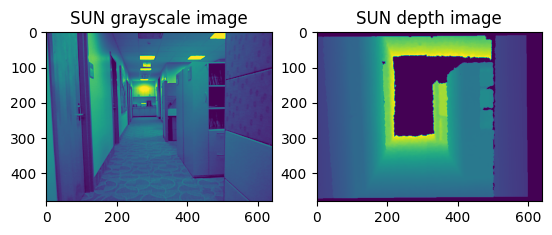

In [9]:
import open3d as o3d
import matplotlib.pyplot as plt
color_raw = o3d.io.read_image("RGBD_Data\SampleSUNRGBDImage\SUN_color.jpg")
depth_raw = o3d.io.read_image("RGBD_Data\SampleSUNRGBDImage\SUN_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('SUN grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('SUN depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [10]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 


## 可视化NYU数据集
NYU数据集的图像不是标准的jpg或png格式，使用mpimg.imread来读取作为numpy数组的彩色图像并将其转换为Open3D图像

- 调用了一个辅助函数read_nyu_pgm，从纽约大学数据集中使用的特殊格式中读取深度图像
- 使用转换函数create_rgbd_image_from_nyu_format来解析SUN数据集中的深度图像



Read NYU dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


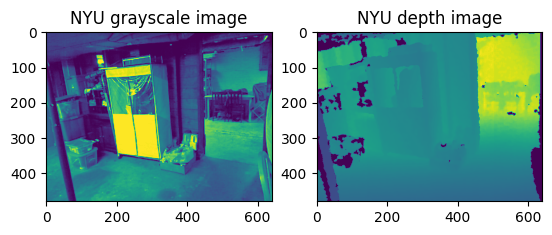

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import re


# This is special function used for reading NYU pgm format
# as it is written in big endian byte order.
def read_nyu_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    img = np.frombuffer(buffer,
                        dtype=byteorder + 'u2',
                        count=int(width) * int(height),
                        offset=len(header)).reshape((int(height), int(width)))
    img_out = img.astype('u2')
    return img_out


print("Read NYU dataset")
# Open3D does not support ppm/pgm file yet. Not using o3d.io.read_image here.
# MathplotImage having some ISSUE with NYU pgm file. Not using imread for pgm.

color_raw = mpimg.imread("RGBD_Data\\SampleNYURGBDImage\\NYU_color.ppm")
depth_raw = read_nyu_pgm("RGBD_Data\\SampleNYURGBDImage\\NYU_depth.pgm")
color = o3d.geometry.Image(color_raw)
depth = o3d.geometry.Image(depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_nyu_format(color, depth)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('NYU grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('NYU depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [7]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

## 可视化TUM数据集
(官方文档下错数据集了)

使用转换函数create_rgbd_image_from_tum_format来解析TUM数据集中的深度图像

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


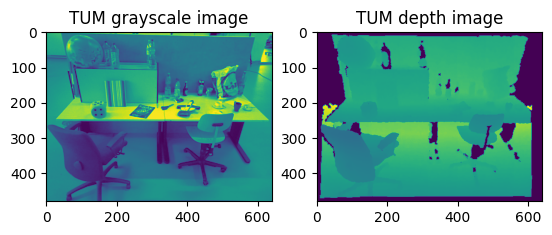

In [11]:
color_raw = o3d.io.read_image("RGBD_Data\SampleTUMRGBDImage\TUM_color.png")
depth_raw = o3d.io.read_image("RGBD_Data\SampleTUMRGBDImage\TUM_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('TUM grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('TUM depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [12]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

# KD树
## 从点云建立DK树

In [43]:
mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/t_pipe.ply")
pcd = mesh.sample_points_uniformly(number_of_points=5000)

# pcd = o3d.io.read_point_cloud("PointCloudData\\yk_examples\\t_pipe.ply")
pcd.paint_uniform_color([0.5, 0.5, 0.5])
pcd_tree = o3d.geometry.KDTreeFlann(pcd)

## 寻找相邻的点

In [44]:
# 挑选第100个（数组以0为索引）点作为锚点，并将其涂成红色

pcd.colors[100] = [1, 0, 0]
o3d.visualization.draw_geometries([pcd])

### KNN搜寻
返回锚点的k个最近的邻居的索引列表

In [46]:
print("Find its 200 nearest neighbors, and paint them blue.")
[k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[100], 30)
np.asarray(pcd.colors)[idx[1:], :] = [0, 0, 1]  # 涂蓝
o3d.visualization.draw_geometries([pcd])

Find its 200 nearest neighbors, and paint them blue.


### 半径搜寻
返回与锚点距离小于给定半径的点

In [47]:
print("Find its neighbors with distance less than 0.2, and paint them green.")
[k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[100], 2)
np.asarray(pcd.colors)[idx[1:], :] = [0, 1, 0]  # 涂绿
o3d.visualization.draw_geometries([pcd])

Find its neighbors with distance less than 0.2, and paint them green.
